#Homework 3: Mining Data Streams

## Report

### Description

The code is split into two parts:
1. Reservoir Sampling
2. Trièst-Base and Trièst-IMPR

***1.*** Reservoir Sampling is an algorithm with the task to approximate the distribution of elements in a stream. Specifically of a stream where the number of elements is unknown. This is done by randomly add abitrary elements from the stream which makes the algorithm efficient. 

***2.*** Trièst-Base and Trièst-IMPR leverage Reservoir Sampling's efficient way of approximating the distribution of the samples to be able to approximate how many triangles there are in a graph structure. This approximation is done by feeding in edges of the graph into the algorithm where at a random time t an element is added to the sample size (representing the true distribution). Furthermore, when an element is added to the samples one element is deleted to sustain the sample size of M. Secondly the algorithm have a global and local triangel counters which is used in the end to approximate the number of triangels. 

Code Structure:

class Reservoir
class Trièst-Base (class Reservoir is not directly used, rather modified within Trièst-Base to make the algorithm more readable)
class Trièst-IMPR (Same goes for class Trièst-IMPR)

### Questions

1. What were the challenges you have faced when implementing the algorithm?

The most difficult part to me was how to store the neighbors of an arbitrary vertice in an efficient way. Likewise, it was rather diffcult to understand how the research paper when to apply this where the notation in some cases was a bit tricky. 

2. Can the algorithm be easily parallelized? If yes, how? If not, why? Explain.

My answer to this is no. The reason for this is the fact that each count is dependant on the previous samples. Therefore, one can not increment the counters in an parallelized manner.

3. Does the algorithm work for unbounded graph streams? Explain.

Yes, it does. The algorithm is not bound to the number of elements in the stream nor is the elements' occurences in the form of probabilities needed to be estimated before hand. However, the estimate of the number of triangles is based on previous elements in the stream and will therefore be updated if the stream continues. 

4. Does the algorithm support edge deletions? If not, what modification would it need? Explain.

No, it does not. However, Trièst-FD does which is the third algorithm presented in the paper. It uses the refined version of Reservoir Sampling called Random Pairing to accomplish this. The reasoning behind Random Pairing is that edge deletions seen on the stream will be compensated by future edge insertions with the help of another counter d. This counter helps to keep track of the number of uncompensated edge deletions by an arbitrary edge ***E*** that was/wasn't in S at the time the deletion for ***E*** was on the stream.

### Result

> ***Presented below***

## Code implementation

### Libraries

In [1]:
import operator
import random
from collections import defaultdict
import time

### TRIÈST - BASE


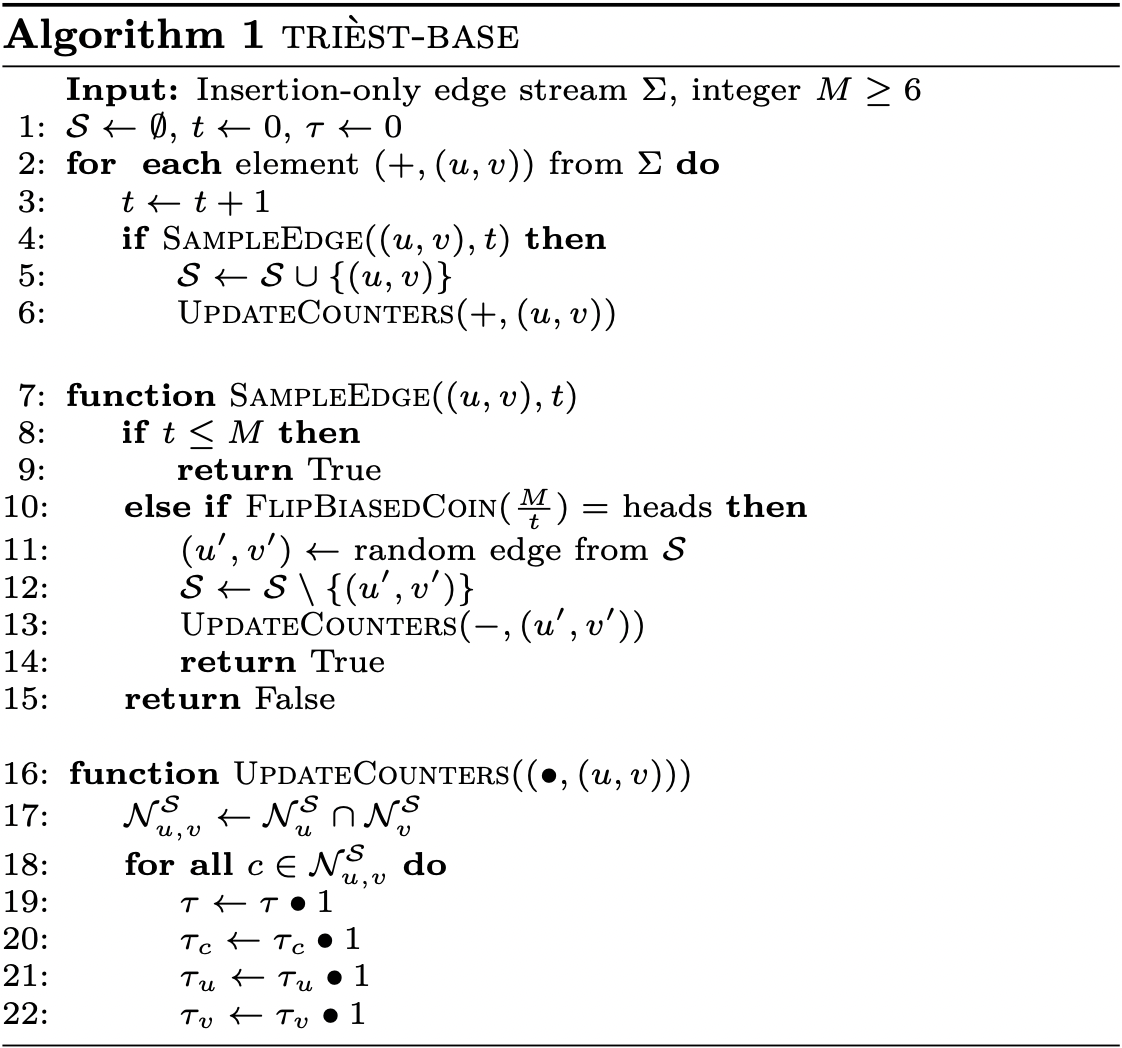

In [21]:
#Import library
from IPython.display import Image
# Load image from local storage
Image(filename = "triestbase.png", width = 500, height = 500)

In [22]:
class TriestBase:
  def __init__(self, M):

    self.M = M
    self.t = 0
    self.global_count = 0
    self.local_count = dict()
    self.Graph = dict()
    self.edges = list()
    self.ops = {
    '+' : operator.add,
    '-' : operator.sub}
  
  
  def addSample(self, edge):
    u, v = edge
    
    self.t += 1
    if self.sampleEdge((u,v)):

      # Add edge to edge samples
      self.edges.append((u,v))
      
      # Add neighbor for both u and v
      # v in u
      if u in self.Graph:
        self.Graph[u].add(v)
      else:
        self.Graph[u] = set([v])
      # u in v
      if v in self.Graph:
        self.Graph[v].add(u)
      else:
        self.Graph[v] = set([u])

      # Add counters
      self.updateCounter('+', (u,v))

  # Start of the algorithm which add an edge or not
  # depending on if t < M, else if biased coin flip --> True
  def sampleEdge(self, edge):
    # RESERVOIR SAMPLING
    u, v = edge
    if self.t <= self.M:
      return True
    elif self.flipBiasedCoin(self.M/self.t):
      
      # Delete edge from samples at random index 
      random_index = random.randint(0, self.M - 1)
      (u1,v1) = self.edges.pop(random_index)

      # Delete neighbor connection in self.Graph of the edges vertices
      self.deleteNeighbor((u1,v1))
      self.deleteNeighbor((v1,u1))
      # Update counter of global and local triangles
      self.updateCounter('-', (u1,v1))

      return True
    return False

  # Biased coinflip
  def flipBiasedCoin(self, p):
    return True if random.random() < p else False

  # Updating the global and local counter which is 
  # used to approximate the number of global and local triangels
  def updateCounter(self, op, edge):
    u,v = edge
    if not u in self.Graph or not v in self.Graph:
      return

    u_neighbors = self.Graph[u]
    v_neighbors = self.Graph[v]

    same_neighbors = u_neighbors & v_neighbors

    same_neighbors_count = len(same_neighbors)
    if same_neighbors_count == 0:
      return

    #Updating counter
    if v not in self.local_count:
      self.local_count[v] = 0
    if u not in self.local_count:
      self.local_count[u] = 0

    # Add neighbors count to global and local[vertice in edge]
    self.global_count = self.ops[op](self.global_count, same_neighbors_count)
    self.local_count[u] = self.ops[op](self.local_count[u], same_neighbors_count)
    self.local_count[v] = self.ops[op](self.local_count[u], same_neighbors_count)

    # Add 1 to the neighboring vertices of u and v
    for c in same_neighbors:
      if c not in self.local_count:
        self.local_count[c] = 0
      self.local_count[c] = self.ops[op](self.local_count[c], 1)
  
  # Estimate Triangles
  def estimateTriangles(self):
    return max(1,int(self.t*(self.t-1)*(self.t-2)/(self.M*(self.M-1)*(self.M-2)))) * self.global_count

  # Deleting Neighbor when an edge is replaced
  def deleteNeighbor(self, edge):
    u, v = edge
    if u in self.Graph:
        self.Graph[u].remove(v)
        if len(self.Graph[u]) == 0:
          del self.Graph[u]



### TRIÈST - IMPR

In [51]:
"""Change to the algorith compared to Trièst-Base
1. Move UpdateCounter before if statement to 19 instead of 35
2. Remove UpdateCounter(-, edge) at row 56
3. Add weight when adding counters as a multiplier"""
class TriestIMPR:
  def __init__(self, M):

    self.M = M
    self.t = 0
    self.global_count = 0
    self.local_count = dict()
    self.Graph = dict()
    self.edges = list()
    self.ops = {
    '+' : operator.add,
    '-' : operator.sub}
  
  def addSample(self, edge):
    u, v = edge
    self.t += 1
    self.updateCounter('+', (u,v)) # CHANGE
    if self.sampleEdge((u,v)):

      # Add edge to edge samples
      self.edges.append((u,v))
      # Add neighbor for both u and v
      # v in u
      if u in self.Graph:
        self.Graph[u].add(v)
      else:
        self.Graph[u] = set([v])
      # u in v
      if v in self.Graph:
        self.Graph[v].add(u)
      else:
        self.Graph[v] = set([u])

      
  # Start of the algorithm which add an edge or not
  # depending on if t < M, else if biased coin flip --> True
  def sampleEdge(self, edge):
    # RESERVOIR SAMPLING
    u, v = edge
    if self.t <= self.M:
      return True
    elif self.flipBiasedCoin(self.M/self.t):
      
      # Delete edge from random index in self.edges
      random_index = random.randint(0, self.M - 1)
      (u1,v1) = self.edges.pop(random_index)

      # Delete neighbor connection in self.Graph
      self.deleteNeighbor((u1,v1))
      self.deleteNeighbor((v1,u1))
      # Update counter of global and local triangles

      #self.updateCounter('-', (u1,v1)). <---- Change

      return True
    return False

  def flipBiasedCoin(self, p):
    return True if random.random() < p else False

  # Updating the global and local counter which is 
  # used to approximate the number of global and local triangels
  def updateCounter(self, op, edge):

    u,v = edge
    # If u or v is not in Graph there is no neighbors
    if not u in self.Graph or not v in self.Graph:
      return

    u_neighbors = self.Graph[u]
    v_neighbors = self.Graph[v]

    same_neighbors = u_neighbors & v_neighbors
    same_neighbors_count = len(same_neighbors)

    # Return if no neighbors
    if same_neighbors_count == 0:
      return
    # CHANGE
    weight = int(max(1,((self.t - 1)*(self.t - 2)/(self.M*(self.M - 1)))))
    
    #Updating counter
    if v not in self.local_count:
      self.local_count[v] = 0
    if u not in self.local_count:
      self.local_count[u] = 0

    self.global_count = self.ops[op](self.global_count, same_neighbors_count*weight)
    self.local_count[u] = self.ops[op](self.local_count[u], same_neighbors_count*weight)
    self.local_count[v] = self.ops[op](self.local_count[u], same_neighbors_count*weight)

    for c in same_neighbors:
      if c not in self.local_count:
        self.local_count[c] = 0
      self.local_count[c] = self.ops[op](self.local_count[c], weight)

  def estimateTriangles(self):
    return self.global_count

  def deleteNeighbor(self, edge):
    u, v = edge
    if u in self.Graph:
        self.Graph[u].remove(v)
        if len(self.Graph[u]) == 0:
          del self.Graph[u]


### Reservoir sampling

In [34]:
class Reservoir:
  def __init__(self, M):
    self.M = M
    self.edge_samples = list()
    self.t = 0

  def add(self, edge):
    size = len(self.edge_samples)
    if size >= self.M:
      rindex = random.randint(0, self.t - 1)
      if rindex < size:
        self.edge_samples[rindex] = edge
    else:
      self.edge_samples.append(edge)
    self.t += 1

### Run the program

In [49]:
edges = set()
with open('web-NotreDame.txt') as f:
    for index, line in enumerate(f):
      if index < 5:
        continue
      edge = tuple(sorted(map(int, line.strip().split())))
      if edge[0] == edge[1]:
        continue
      edges.add(edge)
f.close()

In [50]:
print("Number of edges:", index)
print("Correct Number of Triangels:", 8910005)
for M in [1000, 10000, 50000, 100000]:
  print("Sample size", M)
  reservoir = Reservoir(M)
  triestBase = TriestBase(M)
  triestIMPR = TriestIMPR(M)
  j = 0
  for alg in [reservoir, triestBase, triestIMPR]:
    start_time = time.time()
    for index, edge in enumerate(edges):
      if j == 0:
        alg.add(edge)
      else:
        alg.addSample(edge)
    print(j," Time:", time.time()-start_time, "s")
    if j != 0:
      print(j," Triangles:", alg.estimateTriangles())
    j+=1

Number of edges: 1497137
Correct Number of Triangels: 8910005
Sample size 1000
0  Time: 2.540477991104126 s
1  Time: 1.6790111064910889 s
1  Triangles: 0
2  Time: 2.0909698009490967 s
2  Triangles: 8328828
Sample size 10000
0  Time: 2.4979004859924316 s
1  Time: 2.0726425647735596 s
1  Triangles: 5183196
2  Time: 2.9406068325042725 s
2  Triangles: 9536080
Sample size 50000
0  Time: 2.511876344680786 s
1  Time: 4.250846862792969 s
1  Triangles: 9254159
2  Time: 5.701338291168213 s
2  Triangles: 8891548
Sample size 100000
0  Time: 2.504988193511963 s
1  Time: 7.4119908809661865 s
1  Triangles: 8660960
2  Time: 9.488166332244873 s
2  Triangles: 8756471
